In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from matplotlib.ticker import ScalarFormatter
import mplfinance as mpf
from PIL import Image

In [2]:
df_img_list = pd.read_csv('train_image_level.csv')

In [3]:
df_img_list.head(2)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed


In [4]:
df_img_list['img_path'] = 'train/' + df_img_list['id'].replace('_image', '', regex=True) + '.jpg'
df_img_list['bin_label'] = df_img_list['boxes'].notna().astype(int)

In [5]:
df_img_list.head(2)

,id,boxes,label,StudyInstanceUID,img_path,bin_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/000a312787f2.jpg,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,train/000c3a3f293f.jpg,0


In [6]:
df = df_img_list[['id', 'img_path', 'bin_label']].copy()

In [7]:
df

,id,img_path,bin_label
0,000a312787f2_image,train/000a312787f2.jpg,1
1,000c3a3f293f_image,train/000c3a3f293f.jpg,0
2,0012ff7358bc_image,train/0012ff7358bc.jpg,1
3,001398f4ff4f_image,train/001398f4ff4f.jpg,1
4,001bd15d1891_image,train/001bd15d1891.jpg,1
...,...,...,...
6329,ffcc6edd9445_image,train/ffcc6edd9445.jpg,0
6330,ffd91a2c4ca0_image,train/ffd91a2c4ca0.jpg,0
6331,ffd9b6cf2961_image,train/ffd9b6cf2961.jpg,1
6332,ffdc682f7680_image,train/ffdc682f7680.jpg,1


In [8]:
import numpy as np
from PIL import Image
from skimage.util import view_as_blocks
import cv2
from skimage.feature import hog
from skimage.feature import local_binary_pattern


def compute_cluster_feature(img_path, patch_size=16):
    try:
        img = Image.open(img_path)

        if img.mode == 'RGBA':
            img = img.convert('RGB')  
        img = img.convert("L") 

        img = img.resize((256, 256))
        img_np = np.array(img)

        blocks = view_as_blocks(img_np, block_shape=(patch_size, patch_size))
        means = blocks.mean(axis=(2, 3))
        return means.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
    
def extract_gray_hist(img_path, bins=64):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_hog(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    features, _ = hog(
        img,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True
    )
    return features

def extract_lbp(img_path, P=8, R=1):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    lbp = local_binary_pattern(img, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_combined_features(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        hog_feat, _ = hog(
            img,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            visualize=True,
            feature_vector=True
        )
        gray_hist = cv2.calcHist([img], [0], None, [64], [0, 256])
        gray_hist = cv2.normalize(gray_hist, gray_hist).flatten()

        P, R = 8, 1  
        lbp = local_binary_pattern(img, P, R, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)

        combined = np.concatenate([hog_feat, gray_hist, lbp_hist])
        return combined

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [9]:
df['cluster_feature'] = df['img_path'].apply(compute_cluster_feature)


In [10]:
df['cluster_feature'][0].shape

(256,)

In [11]:
df

,id,img_path,bin_label,cluster_feature
0,000a312787f2_image,train/000a312787f2.jpg,1,"[20.99609375, 24.03515625, 59.0078125, 62.9843..."
1,000c3a3f293f_image,train/000c3a3f293f.jpg,0,"[117.23046875, 122.7421875, 175.01171875, 181...."
2,0012ff7358bc_image,train/0012ff7358bc.jpg,1,"[1.51171875, 12.75390625, 48.71875, 71.0, 56.5..."
3,001398f4ff4f_image,train/001398f4ff4f.jpg,1,"[15.01171875, 28.328125, 1.0234375, 0.0, 0.519..."
4,001bd15d1891_image,train/001bd15d1891.jpg,1,"[24.27734375, 22.5, 21.28125, 21.03125, 20.281..."
...,...,...,...,...
6329,ffcc6edd9445_image,train/ffcc6edd9445.jpg,0,"[56.5078125, 64.75, 67.515625, 65.23046875, 58..."
6330,ffd91a2c4ca0_image,train/ffd91a2c4ca0.jpg,0,"[67.46875, 105.49609375, 98.015625, 100.742187..."
6331,ffd9b6cf2961_image,train/ffd9b6cf2961.jpg,1,"[3.15234375, 17.84765625, 39.625, 62.3671875, ..."
6332,ffdc682f7680_image,train/ffdc682f7680.jpg,1,"[7.140625, 91.02734375, 152.75, 160.98828125, ..."


In [12]:
type(df['cluster_feature'][0])

numpy.ndarray

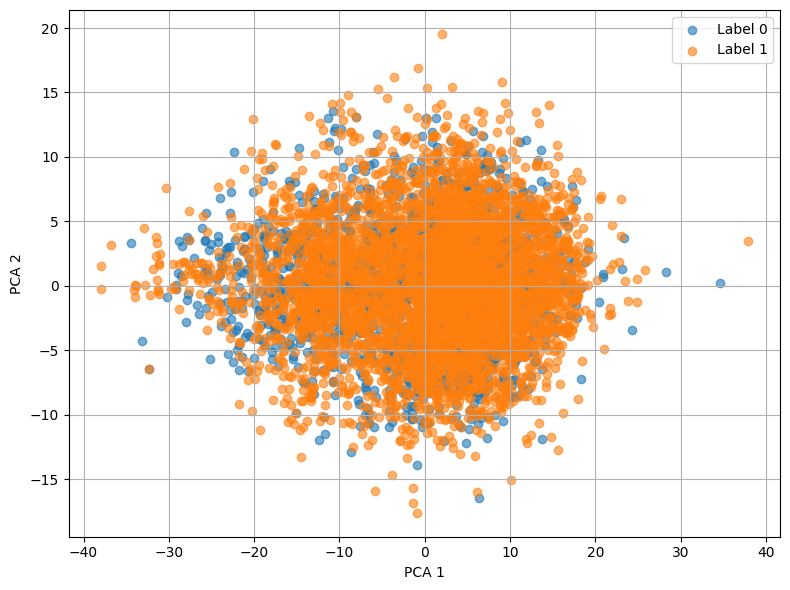

In [13]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

y = df['bin_label'].values  
X_scaled = StandardScaler().fit_transform(np.vstack(df['cluster_feature'].values)  )

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Label {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(df['bin_label'], cluster_labels)
print(f"{ari:.4f}")

0.0039


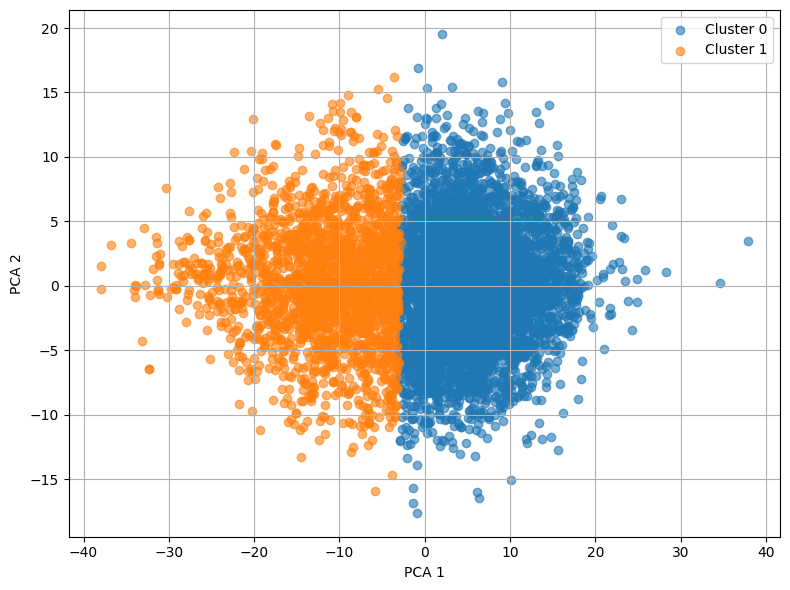

In [15]:
plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(X_scaled)

df['spectral_cluster'] = cluster_labels
ari = adjusted_rand_score(df['bin_label'], cluster_labels)
print(f"{ari:.4f}")


0.0046


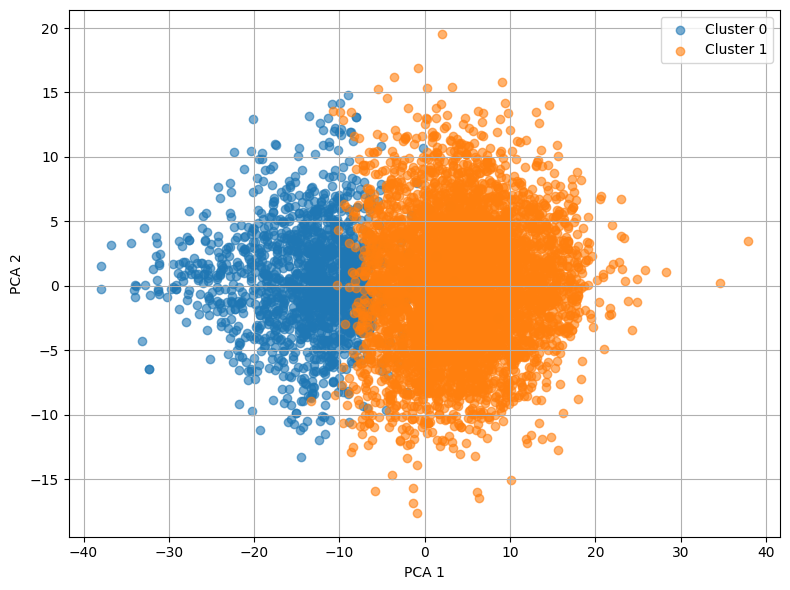

In [17]:

plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled) 

df['gmm_cluster'] = gmm_labels
ari = adjusted_rand_score(df['bin_label'], gmm_labels)
print(f"{ari:.4f}")


-0.0095


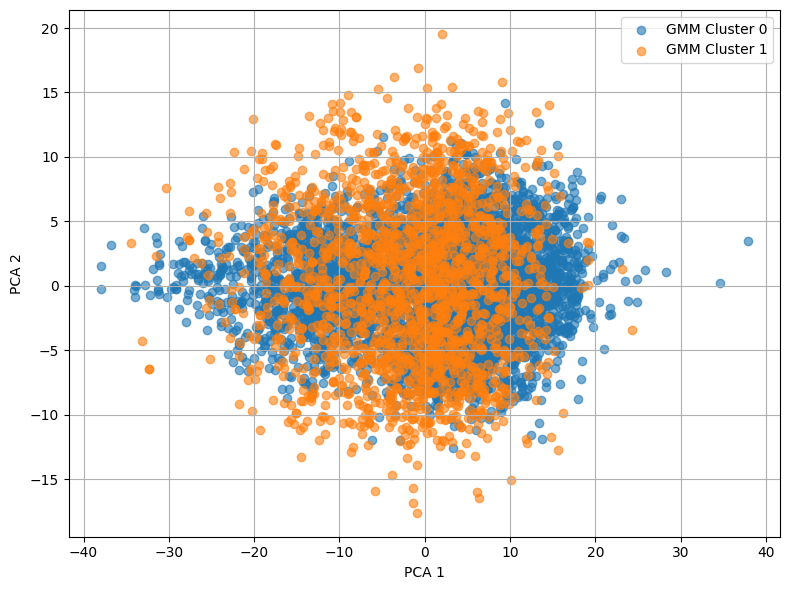

In [19]:
plt.figure(figsize=(8, 6))
for label in np.unique(gmm_labels):
    idx = gmm_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'GMM Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
